In [1]:
import pandas as pd
from sklearn import *
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sabina/anaconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/Users/sabina/anaconda/lib/python2.7/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [2]:
def get_data():
    return pd.DataFrame.from_csv('data/train.csv')

In [48]:
##we only want people with all features
##transform embarked to a numerical value
def fix_data():
    data=get_data()
    
    embarked_change = {'C':0,'Q':1,'S':2}
    
    
    ##faster more pythonic?!
    for row in data['Embarked'].index:
        if pd.notnull(data['Embarked'][row]):
            data['Embarked'][row]=embarked_change[data['Embarked'][row]]
    data['Gender'] = data['Sex'].map({'female' : 0, 'male' : 1}).astype(int) 
    ##add sex 
    
    data.drop(['Ticket','SibSp','Name','Cabin','Embarked','Sex'], axis=1, inplace=True)
    ## combine Age and Parch into Page
    data.Age.fillna(0, inplace=True)
    #data = data[np.logical_not(data.Age.isnull() & data.Parch != 0)].count()
    data['Page'] = data.Parch * data.Age
    data.drop(['Age', 'Parch'], axis=1, inplace=True)
    return data

In [5]:
def combine_predictions(predictions):
    
    combined = np.zeros(len(predictions[0]))
    for p_index in range(len(predictions[0])):
        for prediction in predictions:
            combined[p_index]=combined[p_index]+prediction[p_index]
    return combined/len(predictions)
        

In [6]:
def get_x_y(data,features):
    y = [y for y in data['Survived']]
    xs = [] 
    for row in data.iterrows():
      
        #this_x=[row[1]['Pclass'],row[1]['Fare'],row[1]['Gender'],row[1]['Age'],row[1]['Embarked']]
        this_x=[row[1][f] for f in features]
        xs.append(this_x)
    return xs, y

In [7]:
def get_predictions(model,train_x,train_y,test_x):
    model.fit(train_x,train_y)
    return model.predict(test_x)

In [8]:
def ensembling(rf_go,dt_go,nn_go,ada_go,svm_go):
    fdata = fix_data()
    predictions = []
    
    x,y = get_x_y(fdata,["Pclass","Fare","Gender","Page"])
    train_x,test_x,train_y,test_y = cross_validation.train_test_split(x, y, test_size=0.3, random_state=0)   
    print len(train_x)
    print len(train_y)
    ##Random Forest Classifier
    ##add rf parameter
    if rf_go:
        rf = ensemble.RandomForestClassifier(n_estimators=60)
        predict_rf = get_predictions(rf,train_x,train_y,test_x)
        predictions.append(predict_rf)
    
    ##Decision Trees
    if dt_go:
        dt = tree.DecisionTreeClassifier()
        predict_dt = get_predictions(dt,train_x,train_y,test_x)
        predictions.append(predict_dt)
    ##Nearest Neighbor
    ##add nn parameter
    
    if nn_go:
        nn=neighbors.KNeighborsClassifier(n_neighbors=1)
        predict_nn = get_predictions(nn,train_x,train_y,test_x)
        predictions.append(predict_nn)
    ##
    
    if ada_go:
        ada= ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(),n_estimators=8,learning_rate=.26)
        predict_ada = get_predictions(ada,train_x,train_y,test_x)
        predictions.append(predict_ada)
        
    if svm_go:
        svm_model=svm.SVC(kernel='linear',C=100)
        predict_svm = get_predictions(svm_model,train_x,train_y,test_x)
        predictions.append(predict_svm)
    
    combined = combine_predictions(predictions)
    
    ##assumes equal weight for classifiers
    final_preds = [round(p) for p in combined]
    
    
    
    return test_y,final_preds
    
    

In [15]:
##easiest use cross validation
def get_performance(model,x,y,cv,score):
    return cross_validation.cross_val_score(model, x, y, cv=5,scoring=score)
    

In [55]:
###Let's tune the parameters of the SVM 
def tune_svm(fdata):
    penalties = {} 
    x,y = get_x_y(fdata,["Pclass","Fare","Gender","Page"])

    #penalty = get_performance(model,x,y,5,'f1_weighted')
    #print penalty
    for p in range(1,100,20):
        #p=1.0*p/10.0
       # print p
        model = svm.SVC(kernel='linear',C=p)
#    print model
        penalty = get_performance(model,x,y,5,'accuracy')
        #print np.array(penalty).mean()
        penalties[p]=np.array(penalty).mean()
    return penalties


In [43]:
###Let's tune the parameters of the Nearest Neighbors
def tune_nn(fdata):
    penalties = {} 
    x,y = get_x_y(fdata,["Pclass","Fare","Gender","Page"])

    #penalty = get_performance(model,x,y,5,'f1_weighted')
    #print penalty
    for p in range(1,100,5):
        #p=1.0*p/10.0
       # print p
        model = neighbors.KNeighborsClassifier(n_neighbors=p)
#    print model
        penalty = get_performance(model,x,y,5,'accuracy')
        #print np.array(penalty).mean()
        penalties[p]=np.array(penalty).mean()
    return penalties


In [111]:
##Let's tune the parameters of the Decision Tree


In [112]:
##Let's tune the parameters of the AdaBoost


In [44]:
##Let's tune the parameters of the Random Forest
def tune_rf(fdata):
    penalties = {} 
    x,y = get_x_y(fdata,["Pclass","Fare","Gender","Page"])

    #penalty = get_performance(model,x,y,5,'f1_weighted')
    #print penalty
    for p in range(1,100,10):
        #p=1.0*p/10.0
       # print p
        model = ensemble.RandomForestClassifier(n_estimators=p)
        
        
        
#    print model
        penalty = get_performance(model,x,y,5,'accuracy')
        #print np.array(penalty).mean()
        penalties[p]=np.array(penalty).mean()
    return penalties

In [17]:
def plot_results(x,y,ptitle):
    
    plt.plot(x,y,'o')
    plt.title(ptitle)
    #plt.save

In [49]:
fdata = fix_data()

/Users/sabina/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
fdata.columns

Index([u'Survived', u'Pclass', u'Fare', u'Gender', u'Page'], dtype='object')

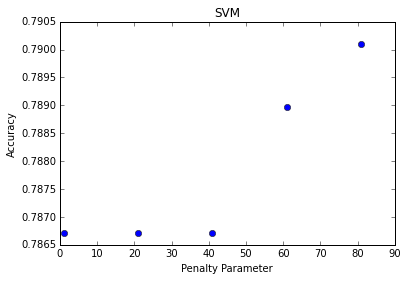

In [56]:
plot_svm(fdata)

In [11]:
def plot_rf(fdata):
    rf_best= tune_rf(fdata)
    x=[]
    y=[]
    for k,v in rf_best.iteritems():
        x.append(k)
        y.append(v)
    plot_results(x,y,'Random Forest')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Estimators')
    plt.savefig('RandomForest.jpg')

In [22]:
def plot_nn(fdata):
    nn_best= tune_nn(fdata)
    x=[]
    y=[]
    for k,v in nn_best.iteritems():
        x.append(k)
        y.append(v)
    plot_results(x,y,'K Nearest Neighbor')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Neighbors')
    plt.savefig('NearestNeighbor.jpg')

In [37]:
def plot_svm(fdata):
    svm_best= tune_svm(fdata)
    x=[]
    y=[]
    for k,v in svm_best.iteritems():
        x.append(k)
        y.append(v)
    plot_results(x,y,'SVM')
    plt.ylabel('Accuracy')
    plt.xlabel('Penalty Parameter')
    plt.savefig('SVM.jpg')

In [107]:
test_y,preds_y = ensembling(True,False,False,True,True)

623
623


/Users/sabina/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [108]:
metrics.accuracy_score(test_y,preds_y)

0.81716417910447758

In [77]:
print len([d for d in data['Parch'] if d==0])
print len([d for d in data['Parch'] if d!=0])
print len([d for d in range(1,len(data["Parch"]),1) if data["Parch"][d]!=0 and not math.isnan(data["Age"][d])])
#print [d for d in data if d["Parch"]!=0]

678
213
193


In [73]:
##Andrei combine age and parch

0

In [7]:

def get_svm_predictions_linear(penalty):
    clf = svm.SVC(kernel='linear',C=penalty)
    return clf
    

In [17]:
def get_logr_predictions():
    logr = linear_model.LogisticRegression()
    return logr

In [ ]:
vm.SVC(kernel='rbf', gamma=0.7, C=C)

In [10]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender"])
model = svm.SVC(kernel='poly', C=1,degree=2)
penalty = get_performance(model,x,y,5,'accuracy')
print np.array(penalty).mean()
#penalty = get_performance(model,x,y,5,'f1_weighted')
#print penalty
#for p in range(1,100,5):
#    for pp in range(1,10,1):
#        e=1.0*p/100.0
#        print e
#        print pp
#        print p
#        model = model = svm.SVC(kernel='rbf', C=p)
    #    print model
#        penalty = get_performance(model,x,y,5,'f1_weighted')
#        print np.array(penalty).mean()
#        penalties.append(penalty)#

KeyboardInterrupt: 

In [83]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender"])
model = svm.SVC(kernel='rbf', C=15)
penalty = get_performance(model,x,y,5,'f1_weighted')
print np.array(penalty).mean()
#penalty = get_performance(model,x,y,5,'f1_weighted')
#print penalty
#for p in range(1,100,5):
#    for pp in range(1,10,1):
#        e=1.0*p/100.0
#        print e
#        print pp
#        print p
#        model = model = svm.SVC(kernel='rbf', C=p)
    #    print model
#        penalty = get_performance(model,x,y,5,'f1_weighted')
#        print np.array(penalty).mean()
#        penalties.append(penalty)#


0.766656963102


In [44]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender"])
model = ensemble.RandomForestClassifier(n_estimators=80)
penalty = get_performance(model,x,y,5,'accuracy')
print np.array(penalty).mean()
#penalty = get_performance(model,x,y,5,'f1_weighted')
#print penalty
for p in range(1,2,1):
#    for pp in range(1,10,1):
#        e=1.0*p/100.0
#        print e
#        print pp
    print p
    model = ensemble.RandomForestClassifier(n_estimators=8)
#    print model
    penalty = get_performance(model,x,y,5,'accuracy')
    print np.array(penalty).mean()
    penalties.append(penalty)

0.779648261039
1
0.785222828315


In [47]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender"])
model = ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(),n_estimators=8,learning_rate=.26)
penalty = get_performance(model,x,y,5,'accuracy')
print np.array(penalty).mean()
#penalty = get_performance(model,x,y,5,'f1_weighted')
#print penalty
#for p in range(1,100,5):
#    for pp in range(1,10,1):
#        e=1.0*p/100.0
#        print e
#        print pp
#        model = ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(),n_estimators=pp,learning_rate=e)
#    print model
#        penalty = get_performance(model,x,y,5,'f1_weighted')
#        print np.array(penalty).mean()
#        penalties.append(penalty)

0.81044926443


In [59]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender"])

#penalty = get_performance(model,x,y,5,'f1_weighted')
print penalty
for p in range(1,100,5):
    #p=1.0*p/10.0
    print p
    model = tree.DecisionTreeClassifier()
#    print model
    penalty = get_performance(model,x,y,5,'f1_weighted')
    print np.array(penalty).mean()
    penalties.append(penalty)

[ 0.70703449  0.78958924  0.79691404  0.73482009  0.81647947]
1
0.789917862019
6
0.789917862019
11
0.78672320631
16
0.78672320631
21
0.789917862019
26
0.78672320631
31
0.78672320631
36
0.78672320631
41
0.78672320631
46
0.78672320631
51
0.78672320631
56
0.78672320631
61
0.78672320631
66
0.78672320631
71
0.78672320631
76
0.789917862019
81
0.78672320631
86
0.78672320631
91
0.78672320631
96
0.78672320631


In [56]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender"])

#penalty = get_performance(model,x,y,5,'f1_weighted')
print penalty
for p in range(1,100,5):
    #p=1.0*p/10.0
    print p
    model = neighbors.KNeighborsClassifier(n_neighbors=p)
#    print model
    penalty = get_performance(model,x,y,5,'f1_weighted')
    print np.array(penalty).mean()
    penalties.append(penalty)

[ 0.49447917  0.73893977  0.62128191  0.66193334  0.6594331 ]
1
0.721350667481
6
0.723067070543
11
0.726811120975
16
0.709844770555
21
0.677001873806
26
0.678824920266
31
0.669958324072
36
0.659815011254
41
0.668266620357
46
0.660203229715
51
0.647797872258
56
0.636403773501
61
0.630807613603
66
0.620827219322
71
0.616110512239
76
0.622355301931
81
0.620334988763
86
0.62256594461
91
0.62598985834
96
0.618324490571


In [44]:
##get x's and y's 
penalties = [] 
x,y = get_x_y(fdata,["Pclass","Fare","Gender","Age","Embarked"])

#penalty = get_performance(model,x,y,5,'f1_weighted')
print penalty
for p in range(1,1000,100):
    #p=1.0*p/10.0
    print p
    model = linear_model.LogisticRegression(C=p)
#    print model
    penalty = get_performance(model,x,y,5,'f1_weighted')
    print np.array(penalty).mean()
    penalties.append(penalty)

[ 0.76283745  0.83045137  0.76816835  0.75131588  0.80876988]
1
0.7830351469
101
0.784308584861
201
0.784308584861
301
0.784308584861
401
0.784308584861
501
0.784308584861
601
0.784308584861
701
0.784308584861
801
0.784308584861
901
0.784308584861


In [29]:
np.array(penalty).mean()

0.77303617590496843

In [46]:
##should take train x, train y, test x, and return predictions for test y 
##should also take whatever parameters you need for this kernel 
##gamma
def get_svm_predictions_rbf(train_x,train_y,test_x):
    pass

In [47]:
##gamma
def get_svm_predictions_poly():
    pass

In [48]:
def get_logistic_regression_predictions():
    pass

In [50]:
##survival per class
classes = data.groupby('Pclass')

In [51]:
print classes.get_group(1)["Survived"].mean()
print classes.get_group(2)["Survived"].mean()
print classes.get_group(3)["Survived"].mean()

0.62962962963
0.472826086957
0.242362525458


In [64]:
for row in data.iterrows():
    print row[1].keys()

Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')
Index([u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'C